In [1]:
import xarray as xr
import act
import pyart
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
radar = "KDMX"
date = "20200810"

In [18]:
wind_data = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/Earnest/wind_product/%s/%s*.nc' %
                              (radar, radar, date))

KeyboardInterrupt: 

In [ ]:
# Remove wind speeds where (1), reflectivity < 10 dBZ and |radial velocity| < 2 m/s
vel_thresh = 2.
refl_thresh = 10. 
inds = np.logical_and(wind_data["reflectivity"] > 0, np.abs(wind_data["corrected_velocity_region_based"]) > 2)
wind_data["spd"] = wind_data["spd"].where(inds)

In [14]:
lon, lat = pyart.core.cartesian_to_geographic(
    wind_data["x"].values, wind_data["y"].values,
    dict(proj="pyart_aeqd", lat_0=wind_data["origin_latitude"].values[0],
    lon_0=wind_data["origin_longitude"].values[0]))

In [15]:
time_window = [datetime(wind_data.time.dt.year[0].values, 
                        wind_data.time.dt.month[0].values,
                        wind_data.time.dt.day[0].values,
                        wind_data.time.dt.hour[0].values, 
                        wind_data.time.dt.minute[0].values, 
                        wind_data.time.dt.second[0].values), 
                        datetime(wind_data.time.dt.year[-1].values, 
                        wind_data.time.dt.month[-1].values,
                        wind_data.time.dt.day[-1].values,
                        wind_data.time.dt.hour[-1].values, 
                        wind_data.time.dt.minute[-1].values, 
                        wind_data.time.dt.second[-1].values)]
station_list_dict = {}
station_list_dict["KDVN"] = ["DVN", "MUT", "MLI", "CWI"]
station_list_dict["KDMX"] = ["DSM", "IKV", "AMW", "BNW"]
station_list_dict["KFSD"] = ["FSD", "MDS"]
station_list_dict["KOAX"] = ["CBF", "OMA", "MLE", "BTA"]
station_list = station_list_dict[radar]
asoses = {}
radar_winds = {}
dists = {}
for station in station_list:
    asoses[station] = act.discovery.get_asos(time_window, station=station)[station]
    asoses[station]["skms"] = asoses[station]["sknt"] * 0.51555555
    asoses[station]["skms"].attrs["units"] = "m s-1"
    lat_index = np.argmin(np.abs(asoses[station].attrs["site_latitude"] - lat))
    lon_index = np.argmin(np.abs(asoses[station].attrs["site_longitude"] - lon))
    radar_winds[station] = wind_data["spd"].isel(x=lat_index, y=lon_index, z=0)
    dists[station] = np.sqrt(wind_data["x"].isel(x=lat_index)**2 + wind_data["y"].isel(y=lat_index)**2).values

Downloading: DSM
Downloading: IKV
Downloading: AMW
Downloading: BNW


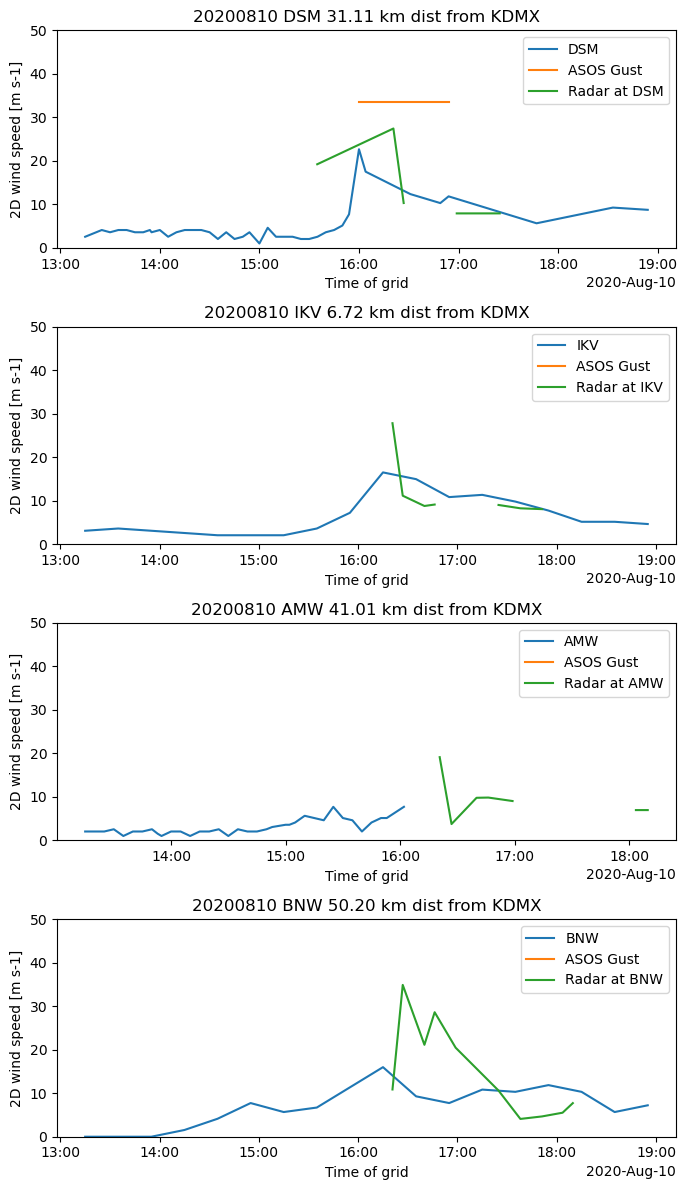

In [16]:
fig, ax = plt.subplots(len(station_list), 1, figsize=(7, 3*len(station_list)))
i = 0
for station in station_list:
    try:
        asoses[station]["skms"].plot(label=station, ax=ax[i])
        asoses[station]["peak_wind_gust"].plot(label="ASOS Gust", ax=ax[i])
    except TypeError:
        d = 0
    radar_winds[station].plot(label='Radar at %s' % station, ax=ax[i])
    ax[i].legend()
    ax[i].set_title("%s %s %3.2f km dist from %s" % (date, station, dists[station] / 1e3, radar))
    ax[i].set_ylim([0, 50])
    i += 1 
fig.tight_layout()
fig.savefig('%s_%s_wind_verif.png' % (date, radar), dpi=150, bbox_inches='tight')

In [ ]:
station = "LSE"
radar = "KARX"
date_list_KFSD = ["20120804", "20130624", "20170721", "20190720", "20200810", 
                  "20211215",  "20220512", "20220705", "20240524"]
date_list_KDMX = ["20130612", "20130624", "20140630", "20170721", "20200810", "20230629"]
date_list_KOAX = ["20130612", "20130624", "20200810", "20211215", "20230629"]
date_list_KDVN = ["20120804", "20130624", "20140630", "20140701", "20170721", "20200810",
                  "20230629", "20240524", ]
date_list_KARX = ["20100618", "20120804", "20130612", "20140630", "20240524"]
dates = date_list_KARX
radar_winds = {}
asoses = {}
obs_winds = {}
for d in dates:
    wind_data = xr.open_dataset(f'/lcrc/group/earthscience/rjackson/Earnest/wind_product_b1/EARNEST.wind.{d}.{radar}.b1.nc')
    inds = np.logical_and(wind_data["reflectivity"] > 0, np.abs(wind_data["corrected_velocity_region_based"]) > 2)
    wind_data["spd"] = wind_data["spd"].where(inds)
    lon, lat = pyart.core.cartesian_to_geographic(
        wind_data["x"].values, wind_data["y"].values,
        dict(proj="pyart_aeqd", lat_0=wind_data["origin_latitude"].values[0].mean(),
        lon_0=wind_data["origin_longitude"].values[0].mean()))
    time_window = [datetime(wind_data.time.dt.year[0].values, 
                            wind_data.time.dt.month[0].values,
                            wind_data.time.dt.day[0].values,
                            wind_data.time.dt.hour[0].values, 
                            wind_data.time.dt.minute[0].values, 
                            wind_data.time.dt.second[0].values), 
                            datetime(wind_data.time.dt.year[-1].values, 
                            wind_data.time.dt.month[-1].values,
                            wind_data.time.dt.day[-1].values,
                            wind_data.time.dt.hour[-1].values, 
                            wind_data.time.dt.minute[-1].values, 
                            wind_data.time.dt.second[-1].values)]
    asoses[d] = act.discovery.get_asos_data(time_window, station=station)[station]
    asoses[d] = asoses[d].drop_duplicates(dim='time', keep='first')
    lat_index = np.argmin(np.abs(asoses[d].attrs["site_latitude"] - lat))
    lon_index = np.argmin(np.abs(asoses[d].attrs["site_longitude"] - lon))
    radar_winds[d] = wind_data["spd"].isel(x=lat_index, y=lon_index, z=0).load()
    obs_winds[d] = asoses[d]["spdms"].reindex(time=radar_winds[d].time, method='nearest').load()
    dist = np.sqrt(wind_data["x"].isel(x=lat_index)**2 + wind_data["y"].isel(y=lat_index)**2).values
    print("%s processsed" % d)
    wind_data.close()

Downloading: LSE
20100618 processsed


: 

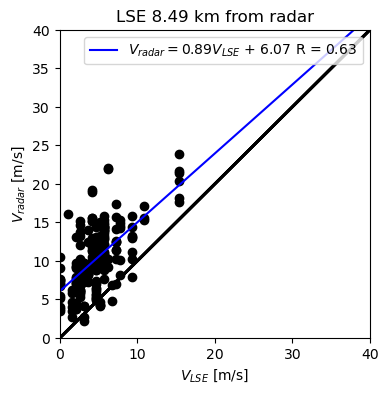

In [4]:
owinds = []
rwinds = []
plt.figure(figsize=(4, 4))
for d in dates:
    obs_winds[d].load()
    radar_winds[d].load()
    owinds.append(obs_winds[d].values)
    rwinds.append(radar_winds[d].values)
    plt.scatter(obs_winds[d], radar_winds[d], color='k')
    plt.plot([0, 40], [0, 40], color='k', linewidth=2)
plt.xlabel('$V_{%s}$ [m/s]' % station)
plt.ylabel('$V_{radar}$ [m/s]')
owinds = np.concatenate(owinds)
rwinds = np.concatenate(rwinds)
where_finite = np.logical_and(np.isfinite(owinds), np.isfinite(rwinds))
r = pearsonr(owinds[where_finite], rwinds[where_finite])
fit = np.polyfit(owinds[where_finite], rwinds[where_finite], 1)
plt.plot([0, 40], np.polyval(fit, [0, 40]), color='b', label='$V_{radar} = %3.2fV_{%s}$ + %3.2f R = %3.2f' % 
         (fit[0], station, fit[1], r.statistic))
plt.title(station + " %4.2f km from radar" % (dist/1e3))
plt.xlim([0, 40])
plt.ylim([0, 40])
plt.legend()
plt.savefig('%s_%s_wind_verif_scatter.png' % (station, radar), dpi=150, bbox_inches='tight')

In [91]:
wind_data["origin_latitude"].values[0]

array([[[43.82277679, 43.82277679, 43.82277679, ..., 43.82277679,
         43.82277679, 43.82277679],
        [43.82277679, 43.82277679, 43.82277679, ..., 43.82277679,
         43.82277679, 43.82277679],
        [43.82277679, 43.82277679, 43.82277679, ..., 43.82277679,
         43.82277679, 43.82277679],
        ...,
        [43.82277679, 43.82277679, 43.82277679, ..., 43.82277679,
         43.82277679, 43.82277679],
        [43.82277679, 43.82277679, 43.82277679, ..., 43.82277679,
         43.82277679, 43.82277679],
        [43.82277679, 43.82277679, 43.82277679, ..., 43.82277679,
         43.82277679, 43.82277679]],

       [[43.82277679, 43.82277679, 43.82277679, ..., 43.82277679,
         43.82277679, 43.82277679],
        [43.82277679, 43.82277679, 43.82277679, ..., 43.82277679,
         43.82277679, 43.82277679],
        [43.82277679, 43.82277679, 43.82277679, ..., 43.82277679,
         43.82277679, 43.82277679],
        ...,
        [43.82277679, 43.82277679, 43.82277679, ..., 4

In [52]:
r

PearsonRResult(statistic=0.7479774667500976, pvalue=5.443756489047344e-65)